# Chapter 05 - Exercise 02

Repeat the analysis of the data in the previous problem with the function

\begin{equation}
    \epsilon(E) = \sin(A(E-E_0))
\end{equation}

(a) Find the posterior probability distribtion for the parameters $(A,E_0)$

(b) Find the 65% CL region for $(A,E_0)$

(c) discuss the results

In [1]:
from __future__ import division 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

from mpl_toolkits.mplot3d import axes3d
from matplotlib import colors, ticker, cm

import math
import time

from scipy.stats import norm
from scipy.stats import binom
from scipy.special import binom as binom_coef

import scipy.integrate as integrate
import scipy.special as special

import progressbar
widgets = [
        'Progress: ', progressbar.Percentage(),
        ' ', progressbar.Bar(marker=progressbar.RotatingMarker()),
        ' ', progressbar.ETA()]


In [2]:
Energies = np.array([0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0])
Trials = np.array([100, 100, 100, 100, 100, 100, 100, 100])
Successes = np.array([0, 4, 22, 55, 80, 97, 99, 99]) 
Rates = Successes/Trials

In [3]:
def epsilon(E, A, E0):
    return np.sin(A*(E-E0))

In [4]:
energies = np.arange(0., 5., 0.1)  # [0.1, 0.2, ..., 4.9]

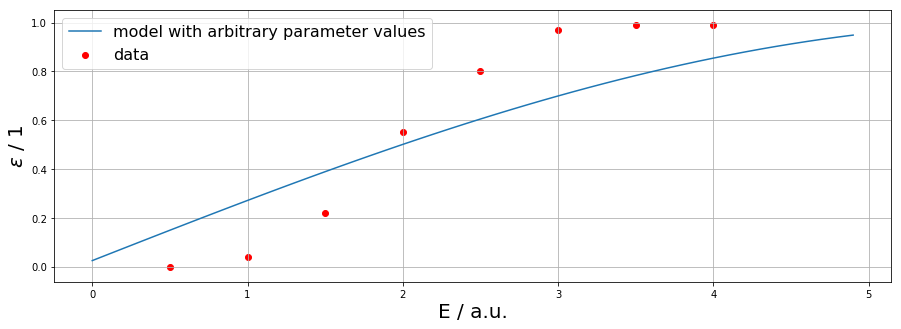

In [5]:
A = 0.25
E0 = -0.1
plt.figure(figsize=(15, 5))
plt.plot(energies, epsilon(energies, A, E0), label="model with arbitrary parameter values")
plt.scatter(Energies, Rates, color="red", label="data")
plt.grid()
plt.xlabel("E / a.u.", fontsize=20)
plt.ylabel(r"$\epsilon$ / 1", fontsize=20)
plt.legend(fontsize=16)
plt.show()

# Posterior:

\begin{align}
    P(\lambda|\{r_i\},\{N_i\}) &= \dfrac{P(\{r_i\}|\{N_i\}, \lambda)\cdot P_0(\lambda)}{\int P(\{r_i\}|\{N_i\}, \lambda)\cdot P_0(\lambda)\textrm{d}\lambda} \\
    &= \dfrac{P(\{r_i\}|\{N_i\}, \lambda)\cdot P_0(A)\cdot P_0(E_0)}{\int P(\{r_i\}|\{N_i\}, \lambda)\cdot P_0(A)\cdot P_0(E_0)\textrm{d}\lambda}
\end{align}

\begin{align}
    P(\{r_i\}|\{N_i\}, \lambda) = \prod\limits_{i=1}^{k}\binom{N_i}{r_i}\epsilon(\lambda)^{r_i}(1-\epsilon(\lambda))^{N_i-r_i}
\end{align}

\begin{align}
    \lambda = [x_i, A, E_0]
\end{align}


\begin{equation}
    \epsilon(\lambda) = \sin(A(E-E_0))
\end{equation}

# Priors:

In [32]:
def gauss(x, mean, sigma):
    return (1./(sigma*np.sqrt(2*np.pi)))*np.exp(-0.5*(x-mean)*(x-mean)/(sigma*sigma))

In [33]:
def prior_A(x):
    return gauss(x, 0.25, 0.2)
    
def prior_E0(x):
    return gauss(x, -0.1, 0.1)

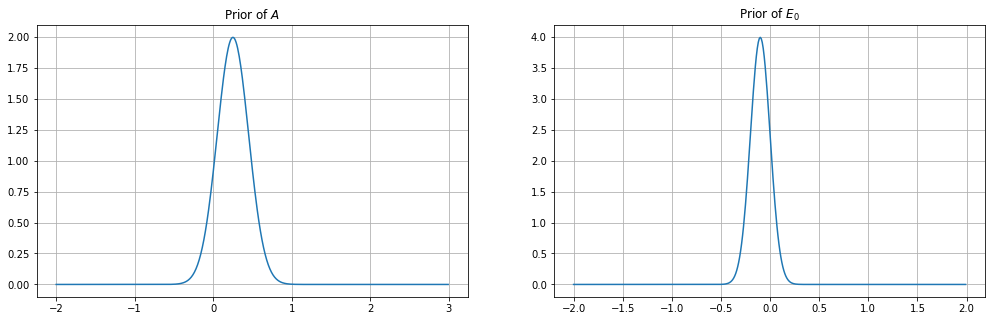

In [34]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(17,5))
x_A = np.arange(-2, 3, 0.01)
x_E0 = np.arange(-2, 2, 0.01)
plt.sca(ax1)
plt.plot(x_A, prior_A(x_A))
plt.title("Prior of $A$")
plt.grid()
plt.sca(ax2)
plt.title("Prior of $E_0$")
plt.plot(x_E0, prior_E0(x_E0))
plt.grid()
plt.show(f)

\begin{align}
    P(\lambda|\{r_i\},\{N_i\}) &= \dfrac{P(\{r_i\}|\{N_i\}, \lambda)\cdot P_0(A)\cdot P_0(E_0)}{\int P(\{r_i\}|\{N_i\}, \lambda)\cdot P_0(A)\cdot P_0(E_0)\textrm{d}\lambda}
\end{align}

In [35]:
def posterior_numerator(A, E0):
    r = 1.
    for i in range(0, len(Trials)): 
        x = Energies[i]
        p = epsilon(x, A, E0)   
        if p <= 0:
            p = 0.
#         print p, prior_A(A), prior_E0(E0), binom.pmf(Successes[i], Trials[i], p)
        r *= binom.pmf(Successes[i], Trials[i], p)*prior_A(A)*prior_E0(E0)
    return r

def posterior_denominator(PS_A, PS_E0):
    n_integral_calculations = len(PS_A)*len(PS_E0)
    print "denominator:"
    bar = progressbar.ProgressBar(widgets=widgets, maxval=n_integral_calculations).start()
    point_n = 0
    integral = 0.
    for a in range(0,len(PS_A)):
        for e0 in range(0,len(PS_E0)):
            integral += posterior_numerator(PS_A[a], PS_E0[e0])
            point_n+=1
            bar.update(point_n)
    bar.finish()   
    time.sleep(0.1)
    return integral

def posterior(A, E0, PS_A, PS_E0):
    return posterior_numerator(A, E0)/posterior_denominator(PS_A, PS_E0)

def pdf(PS_A, PS_E0):
    pdf =  np.zeros((len(PS_A), len(PS_E0)))
    n_grid_points = len(PS_A)*len(PS_E0)
    
    denominator = posterior_denominator(PS_A, PS_E0) 
    time.sleep(0.1)
    print "%d grid points: " % n_grid_points
    bar = progressbar.ProgressBar(widgets=widgets, maxval=n_grid_points).start()
    point_n = 0
    for a in range(0,len(PS_A)):
        for e0 in range(0,len(PS_E0)):
            point_n += 1 
            pdf[a, e0] = posterior_numerator(PS_A[a], PS_E0[e0])/denominator
            bar.update(point_n)
    bar.finish()   
    time.sleep(0.1)
    return pdf


In [36]:
# PS: Parameter space
PS_A_rough = np.arange(0.0, 0.8+0.1, 0.1)
PS_E0_rough = np.arange(-np.pi, np.pi , 0.1)
pdf_grid_rough = pdf(PS_A_rough, PS_E0_rough)
mode_A_rough_idx, mode_E0_rough_idx = np.unravel_index(pdf_grid_rough.argmax(), pdf_grid_rough.shape)
mode_A_rough  = PS_A_rough[mode_A_rough_idx]
mode_E0_rough = PS_E0_rough[mode_E0_rough_idx]
print mode_A_rough, mode_E0_rough

denominator:


Progress: 100% |||||||||||||||||||||||||||||||||||||||||||||||||| Time: 0:00:00


567 grid points: 


Progress: 100% |||||||||||||||||||||||||||||||||||||||||||||||||| Time: 0:00:00


0.3 -0.0415926535898


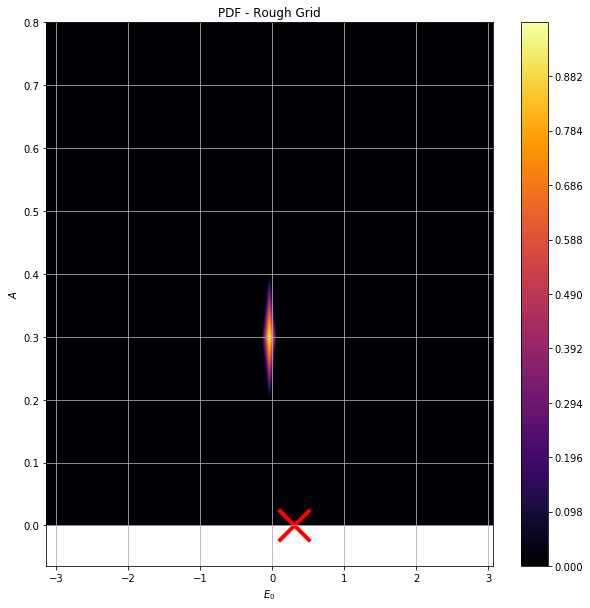

In [55]:
X, Y = np.meshgrid(PS_E0_rough, PS_A_rough)
plt.figure(figsize=(10, 10))
plt.contourf(X,Y,pdf_grid_rough,np.arange(pdf_grid_rough.min(),pdf_grid_rough.max(),.001),label="PDF", cmap='inferno')
plt.xlabel("$E_0$")
plt.ylabel("$A$")
plt.title("PDF - Rough Grid")
plt.grid()
plt.colorbar()
plt.scatter(0.3, 0., label="Prior", color="red", marker="x", s=1000, linewidth=4)
plt.show()

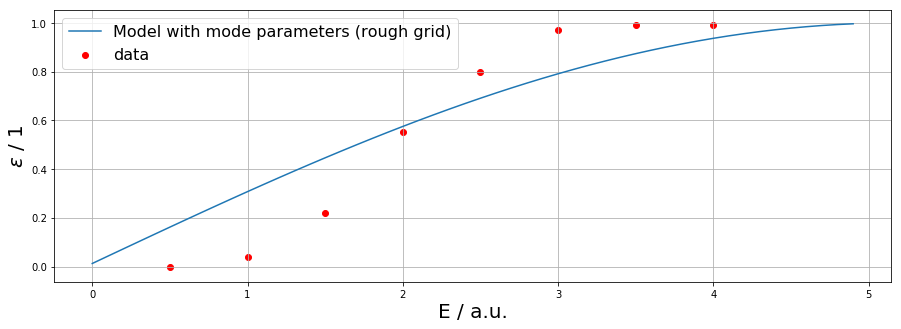

In [38]:
A = mode_A_rough
E0 = mode_E0_rough
plt.figure(figsize=(15, 5))
plt.plot(energies, epsilon(energies, A, E0), label="Model with mode parameters (rough grid)")
plt.scatter(Energies, Rates, color="red", label="data")
plt.grid()
plt.xlabel("E / a.u.", fontsize=20)
plt.ylabel(r"$\epsilon$ / 1", fontsize=20)
plt.legend(fontsize=16)
plt.show()

In [39]:
# PS: Parameter space
PS_A_fine = np.arange(0.30, 0.38+0.001, 0.001)
PS_E0_fine = np.arange(-0.10, 0.1+0.001, 0.001)
pdf_grid_fine = pdf(PS_A_fine, PS_E0_fine)
time.sleep(0.1)
mode_A_fine_idx, mode_E0_fine_idx = np.unravel_index(pdf_grid_fine.argmax(), pdf_grid_fine.shape)
mode_A_fine  = PS_A_fine[mode_A_fine_idx]
mode_E0_fine = PS_E0_fine[mode_E0_fine_idx]
print mode_A_fine, mode_E0_fine

denominator:


Progress: 100% |||||||||||||||||||||||||||||||||||||||||||||||||| Time: 0:00:08


16482 grid points: 


Progress: 100% |||||||||||||||||||||||||||||||||||||||||||||||||| Time: 0:00:08


0.336 8.32667268469e-17


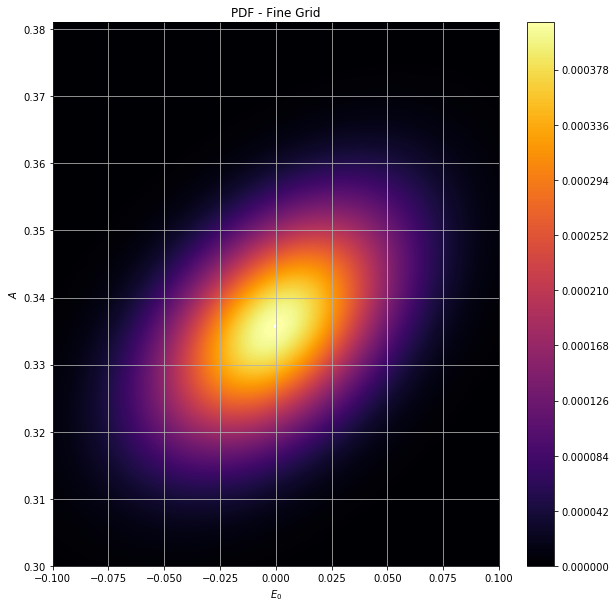

In [51]:
X, Y = np.meshgrid(PS_E0_fine, PS_A_fine)
plt.figure(figsize=(10, 10))
plt.contourf(X,Y,pdf_grid_fine, np.arange(pdf_grid_fine.min(),pdf_grid_fine.max(),.000001), label="PDF", cmap='inferno')
plt.xlabel("$E_0$")
plt.ylabel("$A$")
plt.colorbar()
plt.title("PDF - Fine Grid")
plt.grid()
# plt.scatter(0.3, 0., label="Prior", color="red", marker="+", s=2000)
plt.show()

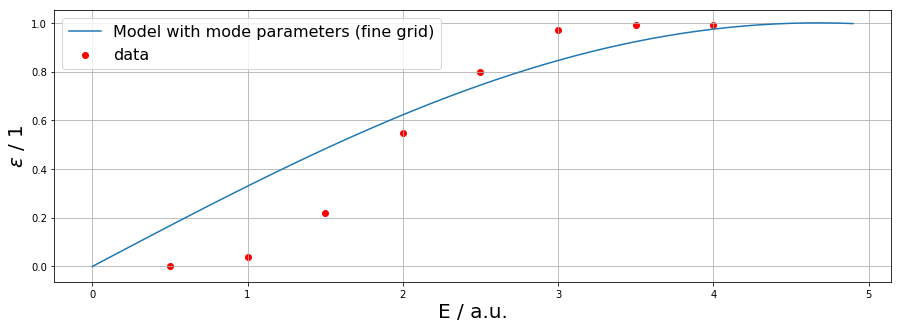

In [49]:
A = mode_A_fine
E0 = mode_E0_fine
plt.figure(figsize=(15, 5))
plt.plot(energies, epsilon(energies, A, E0), label="Model with mode parameters (fine grid)")
plt.scatter(Energies, Rates, color="red", label="data")
plt.grid()
plt.xlabel("E / a.u.", fontsize=20)
plt.ylabel(r"$\epsilon$ / 1", fontsize=20)
plt.legend(fontsize=16)
plt.show()

# Smallest Interval:

In [16]:
def sort_pdf(pdf, PS_A, PS_E0):
    PDF_tripel = []
    for a in range(0,len(PS_A)):
        for e0 in range(0,len(PS_E0)):
            PDF_tripel.append([pdf[a,e0], PS_A[a], PS_E0[e0]])
    PDF_sorted = list(sorted(PDF_tripel, key=lambda x: x[0], reverse=True))
    return PDF_sorted

def get_smallest_interval(pdf_sorted, alpha):
    p_sum = 0.
    i=-1 
    a_arr = []
    e0_arr= []
    while p_sum < alpha:
        i += 1
        p_sum += pdf_sorted[i][0]
        a_arr.append(pdf_sorted[i][1])
        e0_arr.append(pdf_sorted[i][2])
    return a_arr, e0_arr    

In [17]:
PDF_triple = sort_pdf(pdf_grid_fine, PS_A_fine, PS_E0_fine)
SI_68_A, SI_68_E0 = get_smallest_interval(PDF_triple, 0.68)
SI_90_A, SI_90_E0 = get_smallest_interval(PDF_triple, 0.90)
SI_95_A, SI_95_E0 = get_smallest_interval(PDF_triple, 0.95)

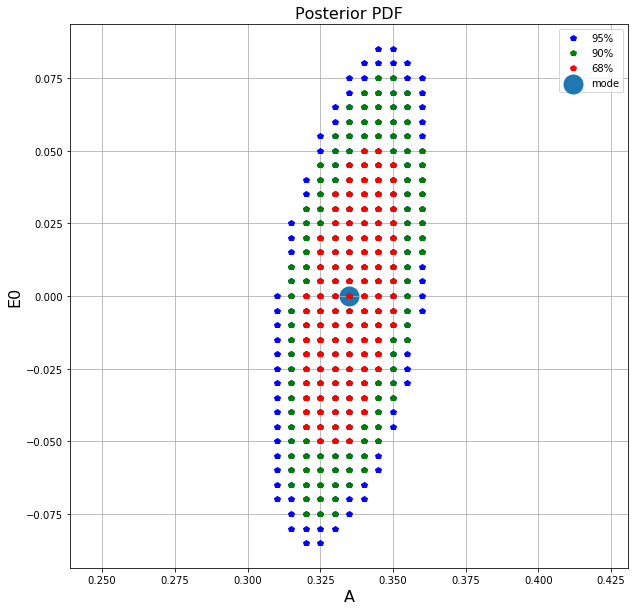

In [18]:
plt.figure(figsize=(10, 10))
plt.plot(SI_95_A,SI_95_E0,'p',c='blue',label='95%')
plt.plot(SI_90_A,SI_90_E0,'p',c='green',label='90%')
plt.plot(SI_68_A,SI_68_E0,'p',c='red',label='68%')
plt.title('Posterior PDF',fontsize=16)
plt.xlabel('A',fontsize=16)
plt.ylabel('E0',fontsize=16)
plt.scatter(PDF_triple[0][1],PDF_triple[0][2],s=100,label='mode', linewidth=10)
plt.grid()
plt.legend()
plt.axis('equal')
plt.show()

# C: Discuss the results

## Smallest Interval for $E_0$ contains positive values

## $\rightarrow$ negative expectation values

## Also:

### It does not discribe the data very well. What happens at larger energies?

## $\rightarrow$ BAD model function

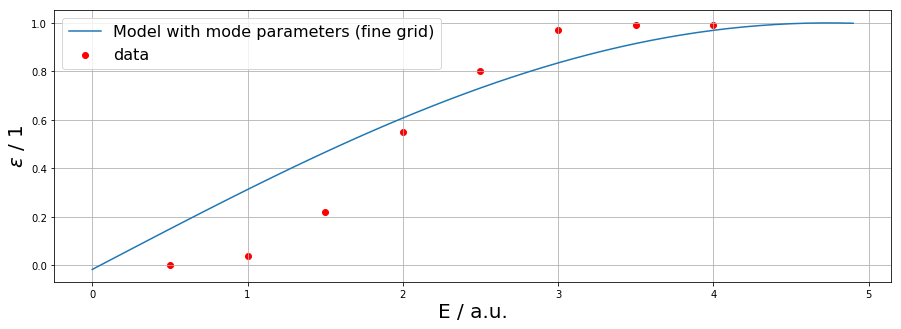

In [19]:
A = PDF_triple[0][1]
E0 = 0.05
plt.figure(figsize=(15, 5))
plt.plot(energies, epsilon(energies, A, E0), label="Model with mode parameters (fine grid)")
plt.scatter(Energies, Rates, color="red", label="data")
plt.grid()
plt.xlabel("E / a.u.", fontsize=20)
plt.ylabel(r"$\epsilon$ / 1", fontsize=20)
plt.legend(fontsize=16)
plt.show()

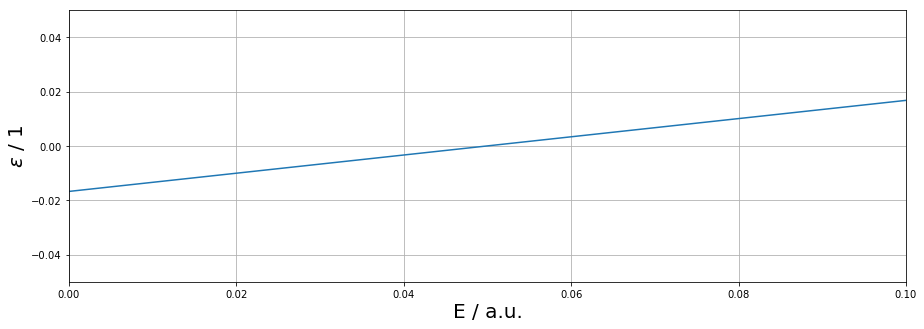

In [20]:
A = PDF_triple[0][1]
E0 = 0.05
plt.figure(figsize=(15, 5))
plt.plot(energies, epsilon(energies, A, E0), label="Model with mode parameters (fine grid)")
plt.scatter(Energies, Rates, color="red", label="data")
plt.grid()
plt.xlim(0., 0.1)
plt.ylim(-0.05, 0.05)
plt.xlabel("E / a.u.", fontsize=20)
plt.ylabel(r"$\epsilon$ / 1", fontsize=20)
plt.show()

# Flat Prior:

In [56]:
# PS: Parameter space
step_size_A  = 0.1
step_size_E0 = 0.01
PS_A_rough = np.arange(0.3, 1., step_size_A)
PS_E0_rough = np.arange(-10*np.pi, 10*np.pi , step_size_E0)

def prior_A(x):
    global PS_A_rough
    return PS_A_rough[-1]-PS_A_rough[0]
    
def prior_E0(x):
    global PS_E0_rough
    return PS_E0_rough[-1]-PS_E0_rough[0]

def posterior_numerator(A, E0):
    r = 1.
    for i in range(0, len(Trials)): 
        x = Energies[i]
        p = epsilon(x, A, E0)   
        if p <= 0:
            p = 0.
        r *= binom.pmf(Successes[i], Trials[i], p)*prior_A(A)*prior_E0(E0)
    return r

def posterior_denominator(PS_A, PS_E0):
    n_integral_calculations = len(PS_A)*len(PS_E0)
    print "denominator:"
    bar = progressbar.ProgressBar(widgets=widgets, maxval=n_integral_calculations).start()
    point_n = 0
    integral = 0.
    for a in range(0,len(PS_A)):
        for e0 in range(0,len(PS_E0)):
            integral += posterior_numerator(PS_A[a], PS_E0[e0])
            point_n+=1
            bar.update(point_n)
    bar.finish()   
    time.sleep(0.1)
    return integral

def posterior(A, E0, PS_A, PS_E0):
    return posterior_numerator(A, E0)/posterior_denominator(PS_A, PS_E0)

def pdf(PS_A, PS_E0):
    pdf =  np.zeros((len(PS_A), len(PS_E0)))
    n_grid_points = len(PS_A)*len(PS_E0)
    
    denominator = posterior_denominator(PS_A, PS_E0) 
    time.sleep(0.1)
    print "%d grid points: " % n_grid_points
    bar = progressbar.ProgressBar(widgets=widgets, maxval=n_grid_points).start()
    point_n = 0
    for a in range(0,len(PS_A)):
        for e0 in range(0,len(PS_E0)):
            point_n += 1 
            pdf[a, e0] = posterior_numerator(PS_A[a], PS_E0[e0])/denominator
            bar.update(point_n)
    bar.finish()   
    time.sleep(0.1)
    return pdf


pdf_grid_rough = pdf(PS_A_rough, PS_E0_rough)
# mode_A_rough_idx, mode_E0_rough_idx = np.unravel_index(pdf_grid_rough.argmax(), pdf_grid_rough.shape)
# mode_A_rough  = PS_A_rough[mode_A_rough_idx]
# mode_E0_rough = PS_E0_rough[mode_E0_rough_idx]
# print mode_A_rough, mode_E0_rough

denominator:


Progress: 100% |||||||||||||||||||||||||||||||||||||||||||||||||| Time: 0:00:20


43988 grid points: 


Progress: 100% |||||||||||||||||||||||||||||||||||||||||||||||||| Time: 0:00:20


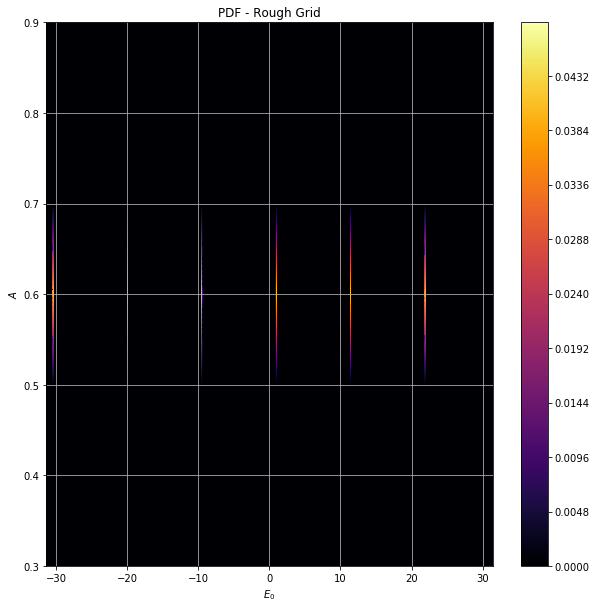

In [75]:
X, Y = np.meshgrid(PS_E0_rough, PS_A_rough)
plt.figure(figsize=(10, 10))
plt.contourf(X,Y,pdf_grid_rough, np.arange(0.000,0.048,.0001), label="PDF", cmap='inferno')
plt.xlabel("$E_0$")
plt.ylabel("$A$")
plt.title("PDF - Rough Grid")
plt.grid()
plt.colorbar()
plt.show()

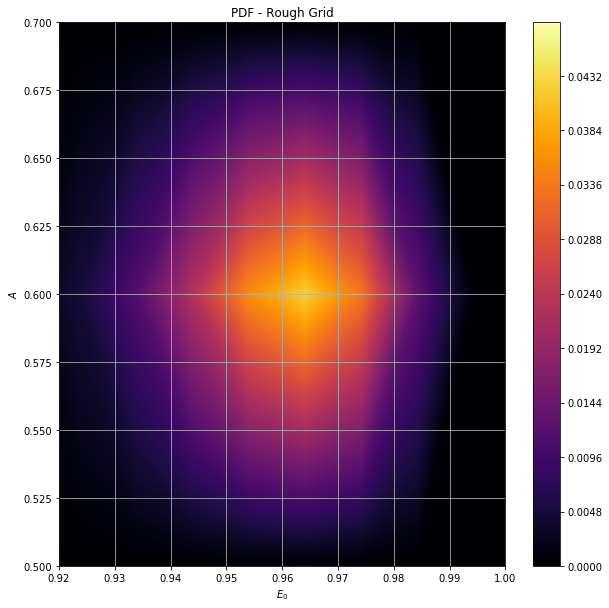

In [74]:
X, Y = np.meshgrid(PS_E0_rough, PS_A_rough)
plt.figure(figsize=(10, 10))
plt.contourf(X,Y,pdf_grid_rough, np.arange(0.000,0.048,.0001), label="PDF", cmap='inferno')
plt.xlabel("$E_0$")
plt.ylabel("$A$")
plt.title("PDF - Rough Grid")
plt.grid()
plt.xlim(0.92, 1.)
plt.ylim(0.5, 0.7)
plt.colorbar()
plt.show()

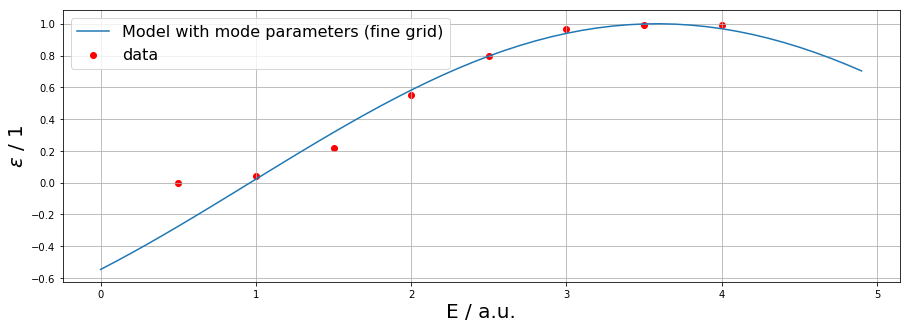

In [29]:
PDF_triple = sort_pdf(pdf_grid_rough, PS_A_rough, PS_E0_rough)

A = PDF_triple[0][1]
E0 = PDF_triple[0][2]
plt.figure(figsize=(15, 5))
plt.plot(energies, epsilon(energies, A, E0), label="Model with mode parameters (fine grid)")
plt.scatter(Energies, Rates, color="red", label="data")
plt.grid()
plt.xlabel("E / a.u.", fontsize=20)
plt.ylabel(r"$\epsilon$ / 1", fontsize=20)
plt.legend(fontsize=16)
plt.show()